### Import the needed libraries

In [1]:
# Install and import the needed libraries
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Package                      Version
---------------------------- -----------
absl-py                      2.1.0
aiofiles                     0.8.0
aiohttp                      3.8.5
aiolimiter                   1.1.0
aiorun                       2023.7.2
aiosignal                    1.3.1
aiosqlite                    0.17.0
asttokens                    2.4.1
astunparse                   1.6.3
async-timeout                4.0.2
asyncpraw                    7.7.1
asyncprawcore                2.3.0
attrs                        23.1.0
bcrypt                       4.0.1
beautifulsoup4               4.12.2
blinker                      1.7.0
cachelib                     0.10.2
certifi                      2023.7.22
charset-normalizer           3.2.0
click                        8.1.7
colorama                     0.4.6
comm               

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
C:\Users\Mirza Anaqi\AppData\Local\Temp\ipykernel_27960\3179175964.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Avoid OOM (out of memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

### Clean the data

In [9]:
import os
import re

data_dir = 'dataset_26'

# Regular expression pattern to match filenames ending with (1), (2), (3), etc.
pattern = re.compile(r'\(\d+\)\.\w+$')

# Iterate over each folder in the dataset
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Iterate over the images in the folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            
            # Check if the filename matches the pattern
            if pattern.search(image):
                # Remove the duplicate image
                os.remove(image_path)

### Load the images

In [10]:
# create data directory and consider only image file format types
# each folder is a category, folder berge is a category mountains and folder stadt is a category city
image_exts = ['jpeg','jpg', 'bmp', 'png']

Found 454 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


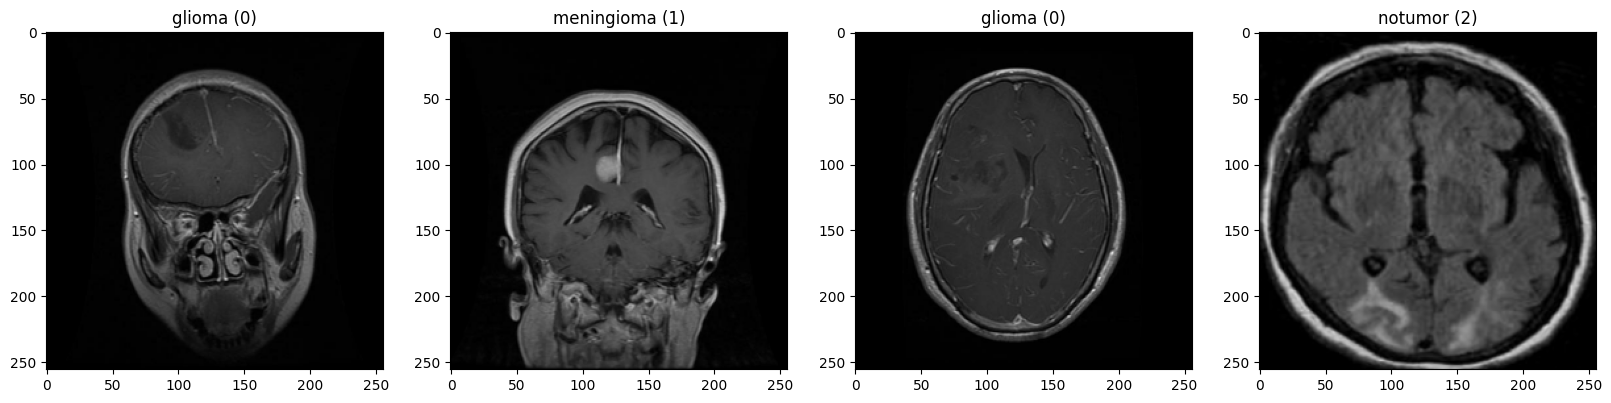

In [21]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

data = tf.keras.utils.image_dataset_from_directory(data_dir)

class_names = data.class_names
print(class_names)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

# establish the data pipeline to load the data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    class_label = class_names[batch[1][idx]]
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f'{class_label} ({batch[1][idx]})')

### Split the images

Scale the data. Map function enanbles transformation inside the pipeline. Split the Data to: 70% Train, 20% Validation and 10% Test. The number of batches is dependent on total sample size.

In [22]:
# Scale the data
# map function enenbles transformation inside the pipeline
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7) # training set will be 70% of data
val_size = int(len(data)*.2) # validation set size will be 20% of data
test_size = int(len(data)*.1) # test size will be 10%

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Build the model

Build the deep Learning Model. Our sequential API is suitable for our basic single input model. Functional API would be more complicated, for multi input, residual networks. Model subclassing would be suitable for layer blocks. MaxPooling2D is condensing image down. The model uses the efficient Adam optimization algorithm for gradient descent, to adjust the weights of the network and to minimize the loss function. Binary Crossentropy computes the cross-entropy loss between true labels and predicted labels.

In [24]:
from tensorflow.keras.models import Sequential # import sequential API. Sequential is good for 1 data input.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers


model = Sequential() # create a model with sequential class

# Layers are added sequentialy
# 1st layer: convolution has 16 filters (3 x 3 pixels inside).
# The power is coming from activation function. Relu is replacing null values.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())

# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten the data again down
model.add(Flatten())

# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values

# Final layer with 4 neurons and softmax activation for 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()
# if the layer is not trainable, there is 0 in Param column
# total params stands for the total size of our model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Fitting the model. Loss is decresing with each epoch and accuracy is raising. The last epoch has 95% accuracy. Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the sigmoid classification technique in the second dense layer. 11 is a sufficient epoch count, more epochs does not lead to better model performance.

In [25]:
# Create a folder to save your callbacks
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

hist.history

Epoch 1/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 721ms/step - accuracy: 0.4383 - loss: 1.2632 - val_accuracy: 0.5521 - val_loss: 0.9799
Epoch 2/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 563ms/step - accuracy: 0.6697 - loss: 0.8670 - val_accuracy: 0.7083 - val_loss: 0.7863
Epoch 3/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.7724 - loss: 0.5966 - val_accuracy: 0.7812 - val_loss: 0.5052
Epoch 4/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step - accuracy: 0.7804 - loss: 0.5142 - val_accuracy: 0.8750 - val_loss: 0.2926
Epoch 5/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.8567 - loss: 0.4248 - val_accuracy: 0.8125 - val_loss: 0.4937
Epoch 6/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 631ms/step - accuracy: 0.8372 - loss: 0.3335 - val_accuracy: 0.9479 - val_loss: 0.1579
Epoch 7/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - accuracy: 0.9614 - loss: 0.1334 - val_accuracy: 0.9271 - val_loss: 0.1937
Epoch 8/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.9426 - loss: 0.1489 - val_accuracy: 0

{'accuracy': [0.48750001192092896,
  0.659375011920929,
  0.7749999761581421,
  0.8187500238418579,
  0.846875011920929,
  0.8656250238418579,
  0.949999988079071,
  0.9437500238418579,
  0.96875,
  0.9781249761581421,
  0.9906250238418579],
 'loss': [1.1754926443099976,
  0.8285044431686401,
  0.5984905958175659,
  0.4649527072906494,
  0.41219472885131836,
  0.30458512902259827,
  0.14373669028282166,
  0.1453920155763626,
  0.1075066477060318,
  0.06346385926008224,
  0.036575861275196075],
 'val_accuracy': [0.5520833134651184,
  0.7083333134651184,
  0.78125,
  0.875,
  0.8125,
  0.9479166865348816,
  0.9270833134651184,
  0.9166666865348816,
  0.9895833134651184,
  1.0,
  0.9791666865348816],
 'val_loss': [0.9798777103424072,
  0.786266565322876,
  0.5052441954612732,
  0.29257872700691223,
  0.4937274754047394,
  0.1578729748725891,
  0.19371671974658966,
  0.2208586186170578,
  0.048996951431035995,
  0.018201539292931557,
  0.046500321477651596]}

### Revise the model performance

If loss and validation go down: OK. If the loss goes down, but validation goes up: model is overfitting and you must change the data. If the loss or valiadation is constant, model is not able to learn and you must change more input parameters. The ideal would be to result in accuracy 100%. Consider more files to increase the accuracy, not only 155 pictures we used.

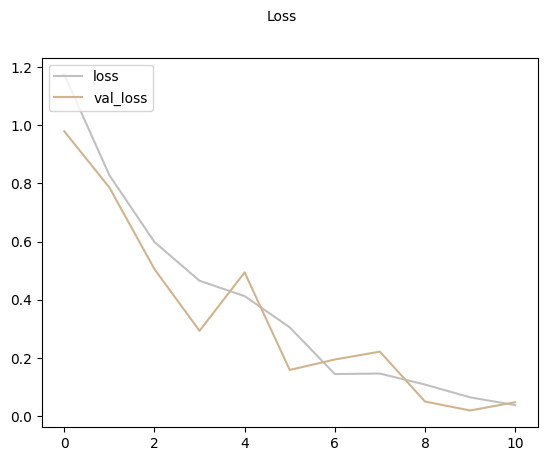

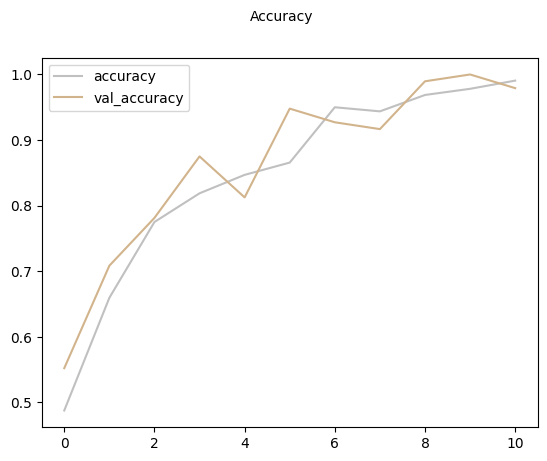

In [26]:
# Revise the model Performance
# if loss and validation go down: OK
# if loss goes down, but validation goes up: model is overfitting. You must change the data.
# if loss or valiadation is constant, model is not able to learn and you must change more parameters.
fig = plt.figure()
plt.plot(hist.history['loss'], color='silver', label='loss')
plt.plot(hist.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

# ideal would be to result in accuracy 100%. Consider more files to increase the accuracy.
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='silver', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

### Classify the new image

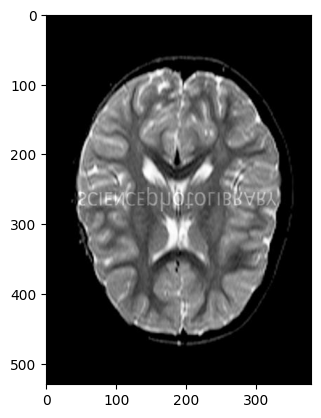

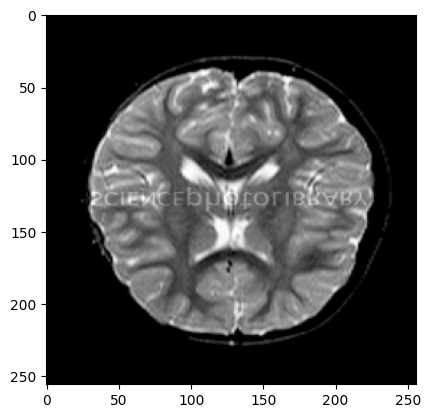

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class is notumor


In [32]:
# Load the image
img = cv2.imread('test4.jpg')  # bgr colors
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change bgr colors to rgb
plt.show()

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize the image
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Expand the dimensions of the resized image
input_image = np.expand_dims(resize / 255.0, 0)  # Normalize the image

# Make the prediction
test_prediction = model.predict(input_image)

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get the predicted class index
predicted_class_index = np.argmax(test_prediction, axis=-1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the prediction
print(f'Predicted class is {predicted_class_name}')